# webtoon_anlaysis

___
### start of fining data

In [1]:
import csv

In [2]:
def read_data(filename):
    with open(filename, 'r',encoding="cp949") as f:
        reader=csv.reader(f)
        lines=list(reader)
        data=[(line[1].replace("\n",""),int(line[2])) for line in lines[1:]]
        print(data[:2])
        texts,ok_points=zip(*data)
        return texts,ok_points
              
        
        
texts, ok_points = read_data('out_put1.csv')


[('잘 되었음 좋겠어요~ 주인공 소연이..', 63), ('핫식스 저렇게 먹으면 없어도 병 없어도 피토하겠다', 63)]


In [3]:
texts[-3:],ok_points[-3:]

(('오', '첫플?', '???'), (1, 1, 1))

In [4]:
len(texts)

111290

### 11만개의 열정호구 댓글을 크롤링 하였음

### start of tokenize
___

In [8]:
texts[:3]

('잘 되었음 좋겠어요~ 주인공 소연이..', '핫식스 저렇게 먹으면 없어도 병 없어도 피토하겠다', '전봇대가 엄청크네요!')

In [9]:
from soynlp.word import WordExtractor

word_extractor=WordExtractor(left_max_length=10, right_max_length=6, min_count=5)
word_extractor.train(texts)
word_scores=word_extractor.word_scores()

training was done. used memory 0.473 Gbmory 0.410 Gb
all cohesion probabilities was computed. # words = 68599
all branching entropies was computed # words = 92579
all accessor variety was computed # words = 92579


In [11]:
word_scores["좁쌀"]

Scores(cohesion_forward=0.92043650793650789, cohesion_backward=0.029293200752485891, left_branching_entropy=4.428760678185551, right_branching_entropy=3.8013760986175136, left_accessor_variety=227, right_accessor_variety=230, leftside_frequency=4639, rightside_frequency=109)

In [12]:
from soynlp.noun import LRNounExtractor

noun_extractor=LRNounExtractor()
nouns=noun_extractor.train_extract(texts)

used default noun predictor; Sejong corpus predictor
used noun_predictor_sejong
2398 r features was loaded
scanning completed
(L,R) has (24574, 14440) tokens
building lr-graph completed

In [20]:
nouns

{'프리랜서': NounScore(frequency=20, score=0.6993755, known_r_ratio=0.8333333333333334),
 '저작권': NounScore(frequency=19, score=0.5007946999999999, known_r_ratio=0.9090909090909091),
 '인정': NounScore(frequency=401, score=0.9101276338028167, known_r_ratio=0.570281124497992),
 '회장': NounScore(frequency=24, score=0.8880967777777777, known_r_ratio=0.6),
 '그러기': NounScore(frequency=15, score=0.9216657142857143, known_r_ratio=0.6363636363636364),
 '56kg': NounScore(frequency=15, score=0.7773004444444445, known_r_ratio=0.6923076923076923),
 '용기': NounScore(frequency=226, score=0.6394769101796408, known_r_ratio=0.8978494623655914),
 '사회초년생': NounScore(frequency=74, score=0.9018476538461537, known_r_ratio=0.43333333333333335),
 '맨처음': NounScore(frequency=11, score=0.999803, known_r_ratio=0.8),
 '만약': NounScore(frequency=131, score=0.99972, known_r_ratio=0.8666666666666667),
 '한마디': NounScore(frequency=258, score=0.8537877062937065, known_r_ratio=0.9050632911392406),
 '와장창': NounScore(frequency=15, s

In [23]:
from soynlp.tokenizer import MaxScoreTokenizer,LTokenizer,RegexTokenizer

tokenizer_scores = {word:score.cohesion_forward * score.right_branching_entropy 
                    for word, score in word_scores.items()}
max_tokenizer = MaxScoreTokenizer(scores = tokenizer_scores)
lt_tokenizer=LTokenizer(scores=tokenizer_scores)




___
### end of tokenizing


### start of word2vec
___

* cohesion과 mecap 토크나이저 이용


In [25]:
import os

class CommentWord2Vec:
    
    def __init__(self, fname):
        self.fname = fname
        if not os.path.exists(fname):
            print('File not found: %s' % fname)
        
            
    def __iter__(self):
        with open(self.fname,encoding="cp949")as f:
            reader=csv.reader(f)
            lines=list(reader)
            for comment in lines[1:]:
                comment_idx,text,score=comment[0],comment[1],comment[2]
                yield text.split()
                
word2vec_corpus=CommentWord2Vec('out_put1.csv')

for num_doc, doc in enumerate(word2vec_corpus):
    if num_doc>5:break
    print(doc)
            
            

['잘', '되었음', '좋겠어요~', '주인공', '소연이..']
['핫식스', '저렇게', '먹으면', '없어도', '병', '없어도', '피토하겠다']
['전봇대가', '엄청크네요!']
['제이름이랑주인공이름이똑같아서', '댓글보면왠지모르게힘이나네요', 'ㅋㅋ우리모두파이팅??']
['아줌씨', '튀긴', '요리는', '많이', '봤자', '입니다.']
['여주가', '저렇게', '이쁠', '수도', '있는데']


In [26]:
texts[:2]

('잘 되었음 좋겠어요~ 주인공 소연이..', '핫식스 저렇게 먹으면 없어도 병 없어도 피토하겠다')

In [27]:
prep_train = list()
count = 0
for each_data in texts:
    doc = each_data
    prep_doc = tokenizer.tokenize(doc)
    if len(prep_doc) > 0: prep_train.append(prep_doc)
    count += 1
    if count%100==0 or count==len(texts)-1: print(count, end='\r')

NameError: name 'tokenizer' is not defined

In [73]:
from gensim.models import Word2Vec

word2vec_model=Word2Vec(prep_train,size=100,
                        alpha=0.025,
                        window=5,
                        min_count=5,
                        sg=0,
                        negative=5,
                        workers=4)

In [74]:
word2vec_model.most_similar("좁쌀",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('편집장', 0.8330658674240112),
 ('조옵살', 0.7467260956764221),
 ('좁살', 0.7033440470695496),
 ('얼굴', 0.7027689218521118),
 ('옵살', 0.6662472486495972)]

In [61]:
word2vec_model.most_similar("은지",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('초롱', 0.716018795967102),
 ('좋으면', 0.670231819152832),
 ('씨가', 0.6645249128341675),
 ('쨩', 0.6581124663352966),
 ('씨한테', 0.6506131291389465)]

In [62]:
word2vec_model.most_similar("초롱",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('씨', 0.7962762117385864),
 ('쨩', 0.7484369874000549),
 ('씨,', 0.7328680753707886),
 ('씨는', 0.7324602603912354),
 ('아가', 0.729434609413147)]

In [63]:
word2vec_model.most_similar("호구",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('열정', 0.8482471108436584),
 ('페이', 0.6370015144348145),
 ('열정페이', 0.6288348436355591),
 ('새출발', 0.6082360744476318),
 ('제목이', 0.5696620941162109)]

In [14]:
import MeCab
import re

In [15]:
t = MeCab.Tagger()

In [16]:
def mecab_NN_parse(text):
    parse_filter = re.compile(r'\S{2,8}\tNN')
    prep_text = parse_filter.findall(t.parse(text))
    nouns_text = [x.replace('\tNN', '') for x in prep_text]
    return nouns_text

In [17]:
prep_train1 = list()
count = 0
for each_data in texts:
    doc = each_data
    prep_doc = mecab_NN_parse(doc)
    if len(prep_doc) > 0: prep_train1.append(prep_doc)
    count += 1
    if count%100==0 or count==len(texts)-1: print(count, end='\r')

In [18]:
prep_train1

[['주인공', '소연'],
 ['핫식스', '피토'],
 ['전봇대'],
 ['이름', '주인공', '이름', '댓글'],
 ['요리', '입니다'],
 ['여주'],
 ['소정', '동생', '부모', '사랑'],
 ['이만화', '소개', '이만화', '처음', '고구마', '시작', '주인공', '인물', '사이다', '고구마'],
 ['소연', '그동안'],
 ['결핵'],
 ['각혈'],
 ['기간', '카페인', '진짜', '사람', '며칠'],
 ['소연', '리즈', '갱신'],
 ['소연', '회사', '퇴사', '희망'],
 ['주인공',
  '동생',
  '하숙집',
  '확률',
  '가족',
  '반대',
  '동생',
  '하숙집',
  '추측',
  '주인공',
  '감시',
  '역할',
  '독립',
  '주인공',
  '동생',
  '부모',
  '허락',
  '가능',
  '주인공',
  '꾸중',
  '하숙집',
  '주인공',
  '동생'],
 ['결국', '친구', '후원금', '용기', '다행', '꽃길'],
 ['현실', '만화', '소연'],
 ['꽃길'],
 ['소연', '친구'],
 ['폭력',
  '부모',
  '단어',
  '인터넷',
  '자유',
  '기고가',
  '성찰',
  '부모',
  '이제',
  '이제',
  '스스로',
  '주력',
  '소연'],
 ['사이다'],
 ['옛날'],
 ['보라색'],
 ['다행', '시작', '소연', '행복', '망이'],
 ['이만화'],
 ['이만화'],
 ['눈동자', '보라색'],
 ['소연', '소리', '치맥', '치킨'],
 ['피래'],
 ['소연', '아파트', '부모', '외부', '출입금', '진데', '가족'],
 ['인정'],
 ['심근', '경색', '증상'],
 ['과로'],
 ['댓글', '불안', '댓글', '동생', '가족', '불안'],
 ['가족', '쓰레기', '진작', '집구석'],
 ['외부', '출입', '금지'

In [75]:
word2vec_model2 = Word2Vec(prep_train1,
                          size=100,
                          alpha=0.025,
                          sg=0,
                          window=5,
                          min_count=5, 
                          workers=4,
                          negative=5)

In [76]:
word2vec_model2.most_similar("좁쌀",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('편집장', 0.9456768035888672),
 ('닷컴', 0.9134986400604248),
 ('여드름', 0.8922123908996582),
 ('최순', 0.8787412643432617),
 ('좁살', 0.875057578086853)]

In [77]:
word2vec_model2.most_similar("은지",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('에이핑크', 0.8685060143470764),
 ('지은', 0.8397077918052673),
 ('다크서클', 0.7933657169342041),
 ('바라기', 0.7930440902709961),
 ('초롱', 0.7698572874069214)]

In [78]:
word2vec_model2.most_similar("초롱",topn=5)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('에이핑크', 0.9194005131721497),
 ('축하', 0.8768541216850281),
 ('미정', 0.8665541410446167),
 ('은진', 0.835301399230957),
 ('박소연', 0.8315212726593018)]

___
### end of word2vec

### start of clustering
___

In [88]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
word2vec_model.wv.syn0.shape

(13321, 100)

In [82]:
word2vec_model2.wv.syn0.shape

(5374, 100)

In [86]:
word2vec_cohesion=normalize(word2vec_model.wv.syn0,axis=1,norm='l2')
word2vec_mecap=normalize(word2vec_model2.wv.syn0,axis=1,norm="l2")

In [128]:
%%time
kmeans=KMeans(n_clusters=6,max_iter=20, n_init=2,verbose=0)
print('kmeans.fit_predict()')
clusters=kmeans.fit_predict(word2vec_cohesion)
print('\n\nkmeans.fit_transform()')
distance = kmeans.fit_transform(word2vec_cohesion)

kmeans.fit_predict()


kmeans.fit_transform()
Wall time: 678 ms


In [129]:
clusters

array([3, 0, 3, ..., 5, 1, 1])

In [130]:
from collections import defaultdict

cluster_to_row = defaultdict(lambda: [])
for row_id, label in enumerate(clusters):
     cluster_to_row[label].append(row_id)
    
cluster_to_row = dict(cluster_to_row)
for label, rows in cluster_to_row.items():
    print('cluster # %d has %d words' % (label, len(rows)))

cluster # 3 has 1154 words
cluster # 0 has 2332 words
cluster # 4 has 1359 words
cluster # 2 has 1585 words
cluster # 1 has 3345 words
cluster # 5 has 3546 words


In [131]:
print(str(word2vec_model.wv.vocab['이']))

Vocab(count:19071, index:3, sample_int:1628001382)


In [132]:
voc=word2vec_model.wv.index2word

In [133]:
for label, rows in cluster_to_row.items():
    print('\ncluster # %d' % label)
    for row in rows[:10]:
        print('  > %s' % voc[row])


cluster # 3
  > ..
  > .
  > 진짜
  > 는
  > 하는
  > 은
  > 하고
  > ㅠㅠ
  > ?
  > 저

cluster # 0
  > ㅋㅋ
  > ㅋ
  > 아
  > 와
  > 네
  > 개
  > ~~
  > ㅡㅡ
  > 이다
  > 극혐

cluster # 4
  > 이
  > 가
  > 도
  > 다
  > 을
  > 아니
  > 안
  > 게
  > 회사
  > 고

cluster # 2
  > !!
  > 제발
  > 싶다
  > 하
  > 나가
  > OOO
  > 이제
  > ~
  > 그럼
  > 한다

cluster # 1
  > 작가님
  > !
  > ㅜㅜ
  > ㅜ
  > 주세요
  > 어
  > 마지막
  > 오
  > 음
  > ㅎ

cluster # 5
  > 10
  > 00
  > 1
  > (
  > 20
  > 후
  > 99
  > 50
  > 눈
  > 내일


In [146]:
%%time
kmeans=KMeans(n_clusters=10,max_iter=300, n_init=2,verbose=0)
print('kmeans.fit_predict()')
clusters=kmeans.fit_predict(word2vec_mecap)
print('kmeans.fit_transform()')
distance = kmeans.fit_transform(word2vec_mecap)

kmeans.fit_predict()


kmeans.fit_transform()
Wall time: 640 ms


In [147]:
from collections import defaultdict

cluster_to_row = defaultdict(lambda: [])
for row_id, label in enumerate(clusters):
     cluster_to_row[label].append(row_id)
    
cluster_to_row = dict(cluster_to_row)
for label, rows in cluster_to_row.items():
    print('cluster # %d has %d words' % (label, len(rows)))

cluster # 6 has 117 words
cluster # 0 has 186 words
cluster # 8 has 145 words
cluster # 2 has 229 words
cluster # 5 has 799 words
cluster # 4 has 1249 words
cluster # 9 has 729 words
cluster # 1 has 457 words
cluster # 7 has 792 words
cluster # 3 has 671 words


In [148]:
voc=word2vec_model2.wv.index2word

In [160]:
for label, rows in cluster_to_row.items():
    print('\ncluster # %d' % label)
    for row in rows[:8]:
        print('  > %s' % voc[row])


cluster # 6
  > 사람
  > 여자
  > 남자
  > 사회
  > 나이
  > 결혼
  > 건데
  > 나라

cluster # 0
  > 부모
  > 생각
  > 엄마
  > 가족
  > 주인공
  > 소연
  > 동생
  > 친구

cluster # 8
  > 회사
  > 퇴사
  > 상사
  > 시간
  > 직장
  > 진상
  > 취업
  > 직원

cluster # 2
  > 작가
  > 사이다
  > 발암
  > 웹툰
  > 만화
  > 현실
  > 고구마
  > 공감

cluster # 5
  > 좁쌀
  > 편집장
  > 새끼
  > 이름
  > 머리
  > 얼굴
  > 최순
  > 순간

cluster # 4
  > 은지
  > 구호
  > 중간
  > 레기
  > 탕수육
  > 기기
  > 사표
  > 기사

cluster # 9
  > 이상
  > 어머님
  > 관심
  > 정의
  > 방법
  > 망이
  > 아줌마
  > 거지

cluster # 1
  > 공부
  > 학교
  > 대학
  > 학생
  > 선생
  > 가능
  > 동안
  > 예전

cluster # 7
  > 시작
  > 차장
  > 걸로
  > 징징
  > 최고
  > 내일
  > 대리
  > 에이핑크

cluster # 3
  > 주제
  > 반대
  > 타령
  > 장애
  > 상관
  > 의미
  > 개소리
  > 아저씨


___
## end of clustering

In [156]:
kmeans.cluster_centers_.shape

(10, 100)

In [164]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

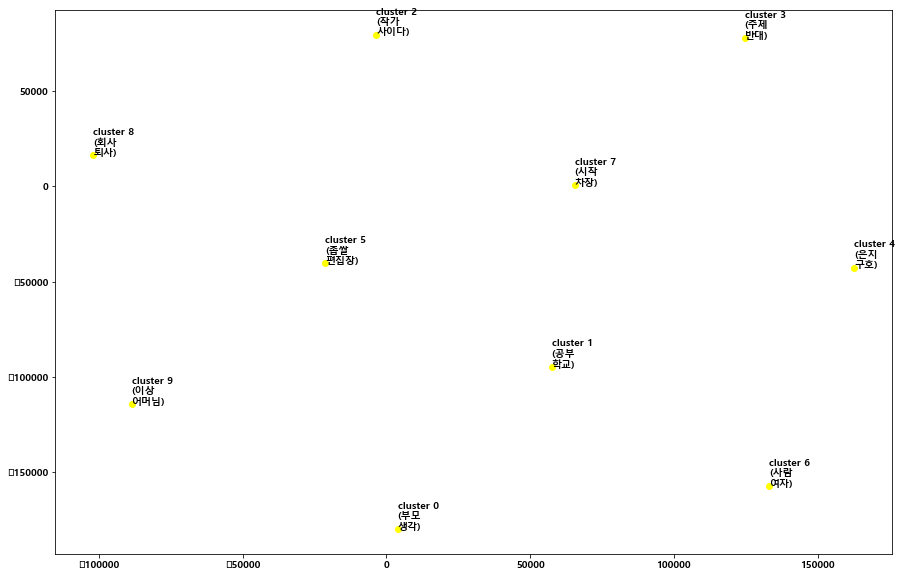

In [165]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
y_tsne = tsne.fit_transform(kmeans.cluster_centers_)
y_tsne = y_tsne*1000


plt.figure(figsize=(15,10))
plt.scatter(y_tsne[:,0], y_tsne[:,1], color='yellow')
for i in range(y_tsne.shape[0]):
    one_sample = voc[cluster_to_row[i][0]]
    two_sample = voc[cluster_to_row[i][1]]
    plt.annotate('cluster %d \n(%s\n%s)' % (i, one_sample, two_sample), 
                 (y_tsne[i, 0], y_tsne[i, 1])
                )
plt.show()

In [166]:
%%time 

from sklearn.manifold import MDS

mds = MDS(n_components=2)
y_mds = mds.fit_transform(kmeans.cluster_centers_)

y_mds.shape

Wall time: 21.1 ms


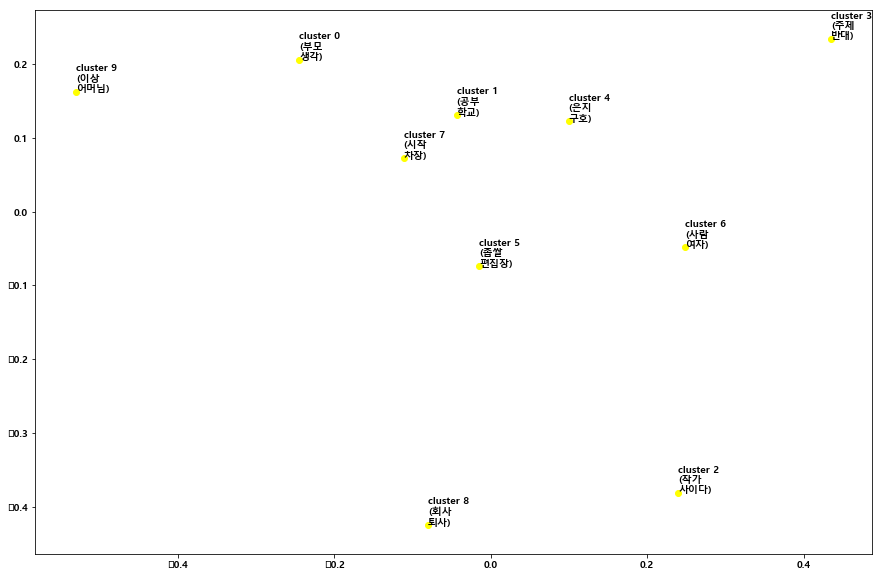

In [169]:
plt.figure(figsize=(15,10))
plt.scatter(y_mds[:,0], y_mds[:,1], color='yellow')
for i in range(y_tsne.shape[0]):
    one_sample = voc[cluster_to_row[i][0]]
    two_sample = voc[cluster_to_row[i][1]]
    plt.annotate('cluster %d \n(%s\n%s)' % (i, one_sample, two_sample), 
                 (y_mds[i, 0], y_mds[i, 1])
                )
plt.show()

